In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import joblib
import os
import glob
import random
from tqdm import tqdm

# Import your modules
from model import VAE_WGAN
from dataset import get_data_loaders

import warnings
warnings.filterwarnings('ignore')


In [13]:
# CONFIGURATION
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "vae_wgan_final.pth"
SVM_PATH = "final_svm_model.pkl" # We will save the SVM here

In [14]:
def extract_features_and_labels(model, loader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in tqdm(loader, desc="Extracting Z-vectors"):
            imgs = imgs.to(DEVICE)

            # Extract Latent Vector (Mean)
            mu, _ = model.encoder(imgs)

            features.append(mu.cpu().numpy())
            labels.append(lbls.numpy())

    return np.concatenate(features, axis=0), np.concatenate(labels, axis=0)

In [15]:
def train_and_save_best_model():
    """
    Retrains the best SVM model on ALL test data and saves it for the demo.
    """
    print("Preparing the Final Detection Model...")
    from sklearn.svm import SVC

    # 1. Load Data & VAE
    _, test_loader = get_data_loaders('modis_dataset_brazil', batch_size=64)
    model = VAE_WGAN().to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))

    # 2. Extract Features
    X, y = extract_features_and_labels(model, test_loader)

    # 3. Train SVM on EVERYTHING (for maximum accuracy)
    clf = SVC(kernel='rbf', probability=True)
    clf.fit(X, y)

    # 4. Save
    joblib.dump(clf, SVM_PATH)
    print(f"Saved optimized classifier to {SVM_PATH}")
    return clf, model

In [16]:
def predict_single_image(image_path, model, clf):
    """
    Runs the full pipeline on a single image file.
    """
    # 1. Load and Preprocess Image
    # We manually replicate the transforms from dataset.py
    img = Image.open(image_path).convert('RGB')
    img_resized = img.resize((64, 64))

    # Convert to Tensor and Normalize [-1, 1]
    img_tensor = torch.tensor(np.array(img_resized)).permute(2, 0, 1).float() / 255.0
    img_tensor = (img_tensor - 0.5) / 0.5
    img_tensor = img_tensor.unsqueeze(0).to(DEVICE) # Add batch dimension

    # 2. Extract Latent Vector (Z)
    with torch.no_grad():
        mu, _ = model.encoder(img_tensor)
        z_vector = mu.cpu().numpy()

    # 3. Classify
    # SVM predicts: Class 0 (Normal) or Class 1 (Fire)
    prob_fire = clf.predict_proba(z_vector)[0][1]

    return prob_fire, img_resized

In [17]:
# Check if we have the saved classifier, if not, create it
if not os.path.exists(SVM_PATH):
    clf, model = train_and_save_best_model()
else:
    print("Loading existing detection system...")
    clf = joblib.load(SVM_PATH)
    model = VAE_WGAN().to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()

Loading existing detection system...


In [18]:
# --- SIMULATION LOOP ---
# Pick random images from the dataset to test
fire_dir = os.path.join('modis_dataset_brazil', 'fire_anomalies')
normal_dir = os.path.join('modis_dataset_brazil', 'normal_reference')

In [19]:
fire_files = glob.glob(os.path.join(fire_dir, "*.png"))
normal_files = glob.glob(os.path.join(normal_dir, "*.png"))

In [20]:
# Pick 3 Fires and 3 Normal images
test_files = random.sample(fire_files, 3) + random.sample(normal_files, 3)
random.shuffle(test_files)


Starting Live Detection Simulation...
Image 1: ✅ Normal Forest Safe (19.3% risk)
Image 2: 🚨 FIRE DETECTED! Conf: 84.3%
Image 3: ✅ Normal Forest Safe (22.8% risk)
Image 4: ✅ Normal Forest Safe (33.4% risk)
Image 5: ✅ Normal Forest Safe (19.3% risk)
Image 6: 🚨 FIRE DETECTED! Conf: 96.5%

Simulation complete. Results saved to 'demo_results.png'


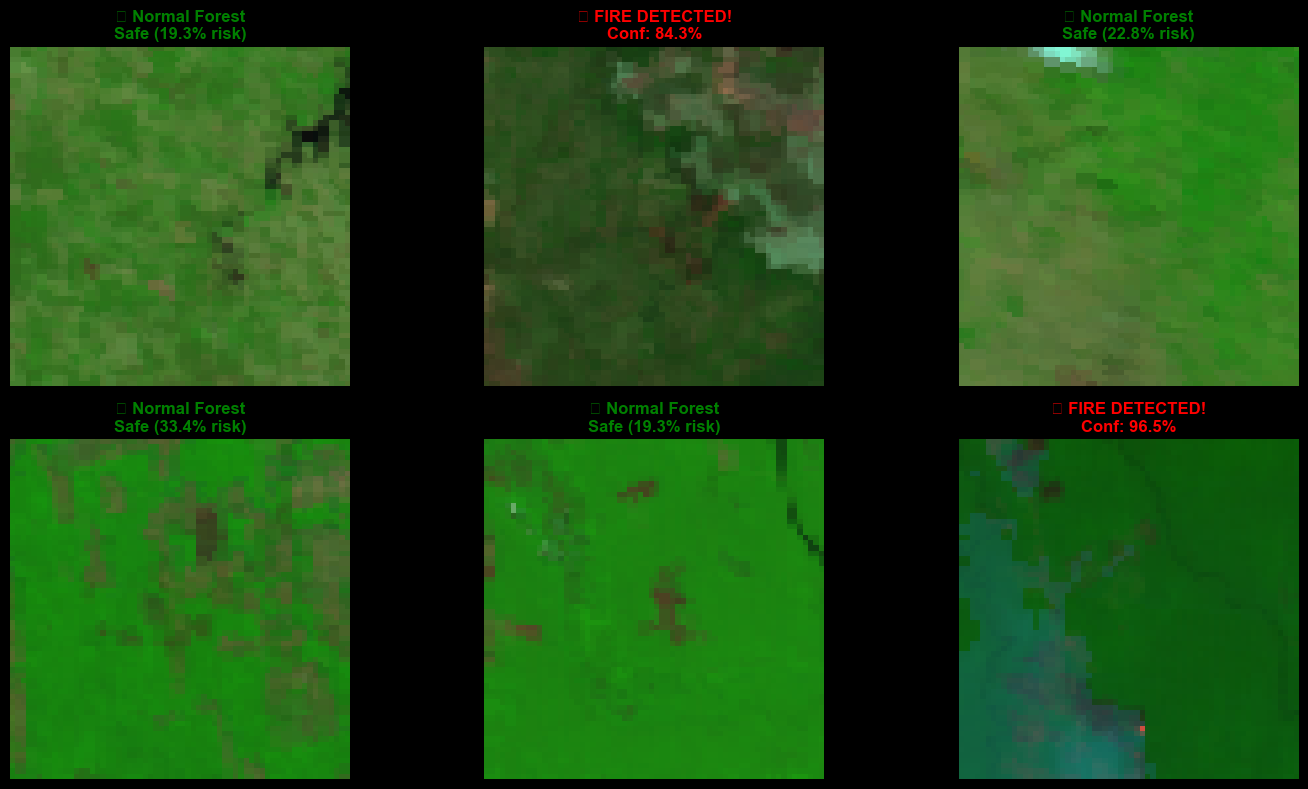

In [21]:
print("\nStarting Live Detection Simulation...")
plt.figure(figsize=(15, 8))

for i, fpath in enumerate(test_files):
    # Run Detection
    prob, img = predict_single_image(fpath, model, clf)

    # Display
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.axis('off')

    # Color code the title
    if prob > 0.50:
        title = f"🚨 FIRE DETECTED!\nConf: {prob*100:.1f}%"
        color = 'red'
    else:
        title = f"✅ Normal Forest\nSafe ({prob*100:.1f}% risk)"
        color = 'green'

    plt.title(title, color=color, fontweight='bold', fontsize=12)
    print(f"Image {i+1}: {title.replace(chr(10), ' ')}")

plt.tight_layout()
plt.savefig("demo_results.png")
print("\nSimulation complete. Results saved to 'demo_results.png'")